# Birds Detection using YOLOv8
This notebook demonstrates how to build and train a custom YOLOv8 model for detecting birds in images. We'll use the Roboflow platform for dataset management and the Ultralytics implementation of YOLOv8.

## Table of Contents
1. [Setup and Installation](#setup-and-installation)
2. [Dataset Preparation](#dataset-preparation)
3. [Model Training](#model-training)
4. [Image Detection](#image-detection)
5. [Video Detection](#video-detection)

## 1. Setup and Installation

First, we'll install the required packages:

In [ ]:
# Install required packages
%pip install roboflow ultralytics supervision

# Install tree command for dataset structure visualization
!apt-get install tree

Import necessary libraries

In [1]:
from ultralytics import YOLO
from roboflow import Roboflow
import supervision as sv
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import requests

## 2. Dataset Preparation

### 2.1 Download Dataset from Roboflow
Connect to Roboflow and download the wild animals detection dataset:

In [ ]:
# Initialize Roboflow and download dataset
# Replace YOUR_API_KEY with your actual Roboflow API key
rf = Roboflow(api_key="YOUR_API_KEY")
project = rf.workspace("puspendu-ai-vision-workspace").project("birds-detection-uem1j")
version = project.version(1)
dataset = version.download("yolov8")


### 2.2 Check Dataset Structure
Use the tree command to visualize the dataset structure:


In [ ]:
!tree -L 2 "BIRDS-DETECTION-1"

## 3. Model Training
**Important Notes**:

 - Make sure to update the path in data.yaml file with the absolute path of your dataset
 - We're using YOLOv8-large (yolov8l.pt) as our base model
 - Training parameters are set to 100 epochs with 640x640 image size

In [ ]:
model = YOLO('yolov8l.pt')
model.train(
    data = "BIRDS-DETECTION-1/data.yaml",
    epochs = 100, 
    imgsz = 640
    )

## 4. Image Detection

Here's our comprehensive function for detecting birds in images:

In [32]:
def display_prediction(image_path, save_fig=False, filename=None):
    """
    Function to display predictions of a pre-trained YOLO model on a given image.
    
    Parameters:
        image_path (str): Path to the image file. Can be a local path or a URL.
        save_fig (bool): If True, saves the predicted image with annotations. Default is False.
        filename (str): Name of the file to save the image. Required if save_fig is True.
    """

    # Load YOLO model
    model = YOLO("runs/detect/train/weights/best.pt")
    class_dict = model.names

    # Load image from local path or URL
    if image_path.startswith(('http', 'https')):
        try:
            response = requests.get(image_path)
            image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
            img = cv.imdecode(image_array, cv.IMREAD_COLOR)
        except Exception as e:
            print(f"Error loading image from URL: {e}")
            return
    else:
        img = cv.imread(image_path)
    
    # Check if image was loaded successfully
    if img is None:
        print("Couldn't load the image! Please check the image path.")
        return

    # Get image dimensions
    h, w = img.shape[:2]

    # Calculate optimal thickness for boxes and text based on image resolution
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=(w, h))
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=(w, h))

    # Set up color palette for annotations
    color_palette = sv.ColorPalette.from_matplotlib('magma', 10)

    # Create box and label annotators
    box_annotator = sv.BoxAnnotator(thickness=thickness, color=color_palette)
    label_annotator = sv.LabelAnnotator(color=color_palette, text_scale=text_scale, 
                                        text_thickness=thickness, 
                                        text_position=sv.Position.TOP_LEFT)

    # Run the model on the image
    result = model(img)[0]

    # Convert YOLO result to Detections format
    detections = sv.Detections.from_ultralytics(result)

    # Filter detections based on confidence threshold and check if any exist
    if detections.class_id is not None:
        detections = detections[(detections.confidence > 0.5)]

        # Create labels for the detected objects
        labels = [f"{class_dict[cls_id]} {conf*100:.2f}%" for cls_id, conf in 
                  zip(detections.class_id, detections.confidence)]

        # Annotate the image with boxes and labels
        box_annotator.annotate(img, detections=detections)
        label_annotator.annotate(img, detections=detections, labels=labels)

    # Display the annotated image
    dpi = 120
    fig_w, fig_h = int(img.shape[1]/dpi), int(img.shape[0]/dpi)
    fig = plt.figure(figsize=(fig_w, fig_h))
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')

    # Save the image if requested
    if save_fig:
        if filename:
            save_dir = "DATA/IMAGES/detected_images"
            os.makedirs(save_dir, exist_ok=True)  # Ensure the save directory exists
            save_path = os.path.join(save_dir, filename)
            try:
                fig.savefig(save_path, bbox_inches='tight', dpi=200)
                print(f"Image saved successfully at {save_path}")
            except Exception as e:
                print(f"Error saving image: {e}")
        else:
            print("Filename is required to save the figure.")
    
    # Display the image in the output
    plt.show()



0: 448x640 2 Crows, 1042.6ms
Speed: 8.0ms preprocess, 1042.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
Image saved successfully at DATA/IMAGES/detected_images\crows_detected_1.jpg


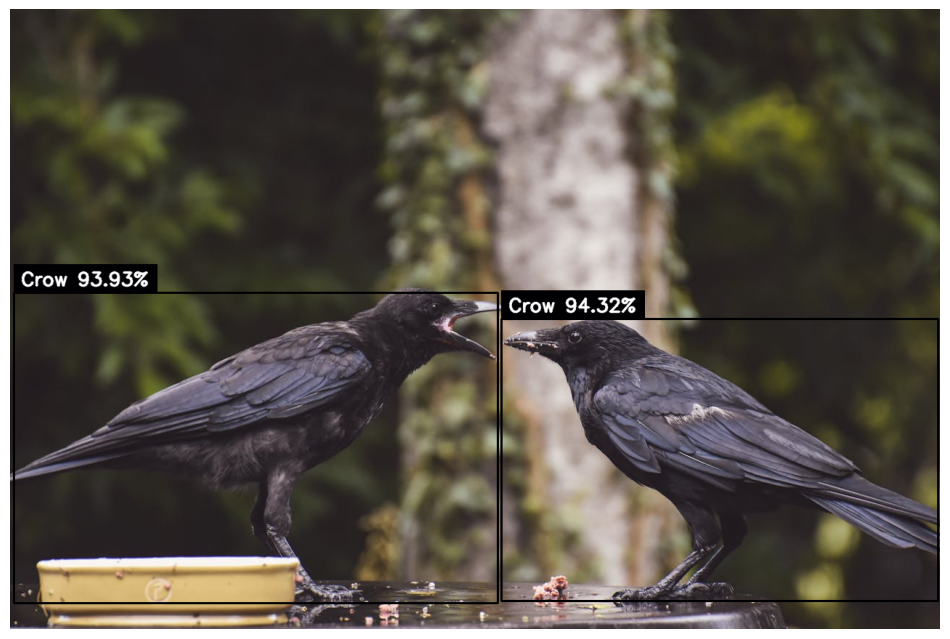

In [5]:
display_prediction("DATA/IMAGES/test_images/crows_1.jpg",
                    save_fig=True, filename='crows_detected_1.jpg'
                    )


0: 448x640 34 Crows, 981.1ms
Speed: 8.0ms preprocess, 981.1ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)
Image saved successfully at DATA/IMAGES/detected_images\crows_detected_2.jpg


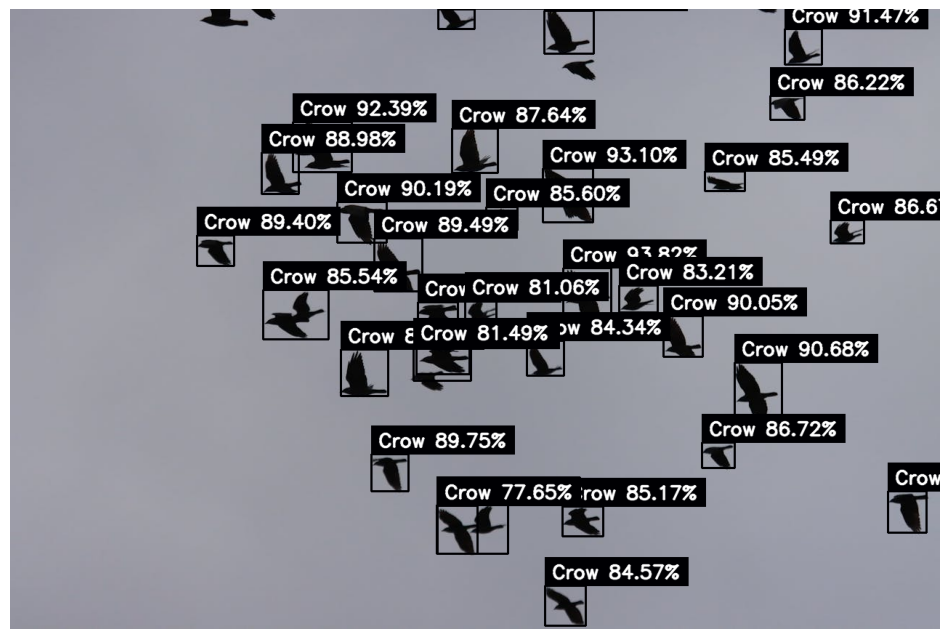

In [9]:
display_prediction("DATA/IMAGES/test_images/crows_3.jpg",
                    save_fig=True, filename='crows_detected_2.jpg'
                    )


0: 448x640 13 Crows, 1182.2ms
Speed: 6.5ms preprocess, 1182.2ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)
Image saved successfully at DATA/IMAGES/detected_images\crows_detected_4.jpg


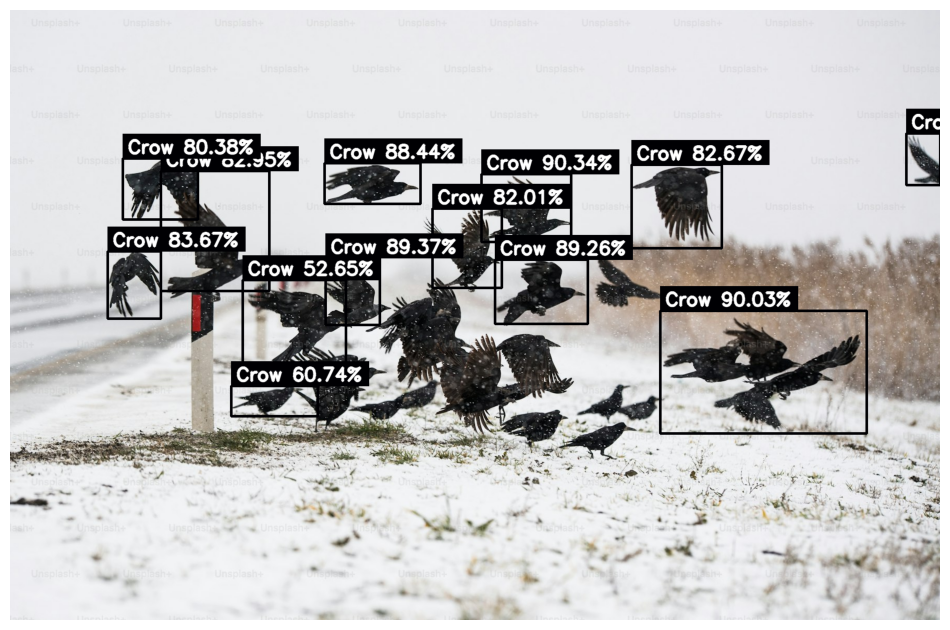

In [12]:
display_prediction(
    "https://plus.unsplash.com/premium_photo-1661962463238-bdfc69274ad4?q=80&w=1784&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D", 
    save_fig=True, 
    filename='crows_detected_4.jpg'
    )


0: 448x640 2 Kingfishers, 1135.4ms
Speed: 5.3ms preprocess, 1135.4ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)
Image saved successfully at DATA/IMAGES/detected_images\kingfishers_detected.jpg


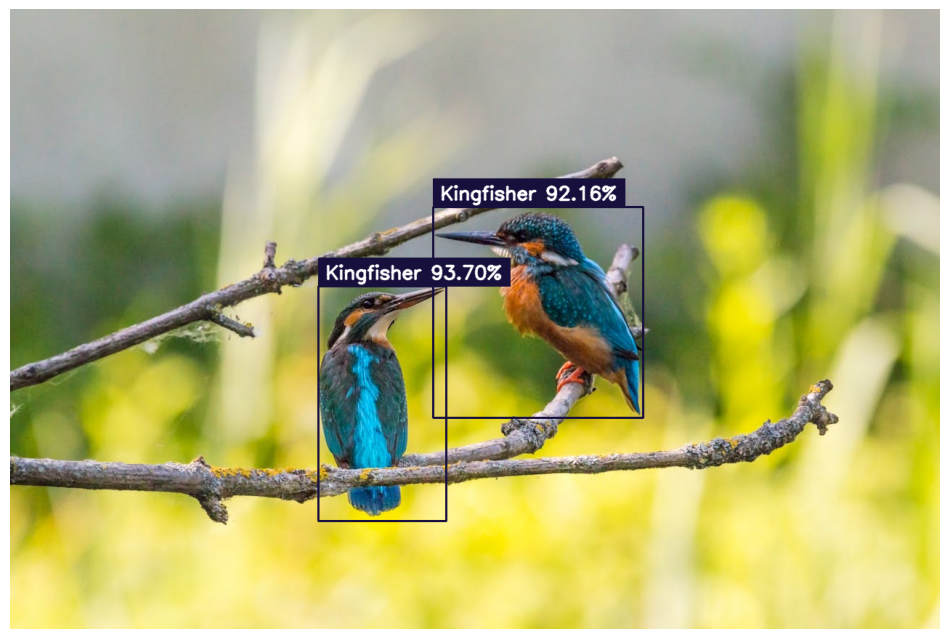

In [15]:
display_prediction(
    "DATA/IMAGES/test_images/kingfisher_2.jpg",
    save_fig=True, 
    filename='kingfishers_detected.jpg'
)


0: 640x448 1 Myna, 833.6ms
Speed: 5.4ms preprocess, 833.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)
Image saved successfully at DATA/IMAGES/detected_images\myna_detected.jpg


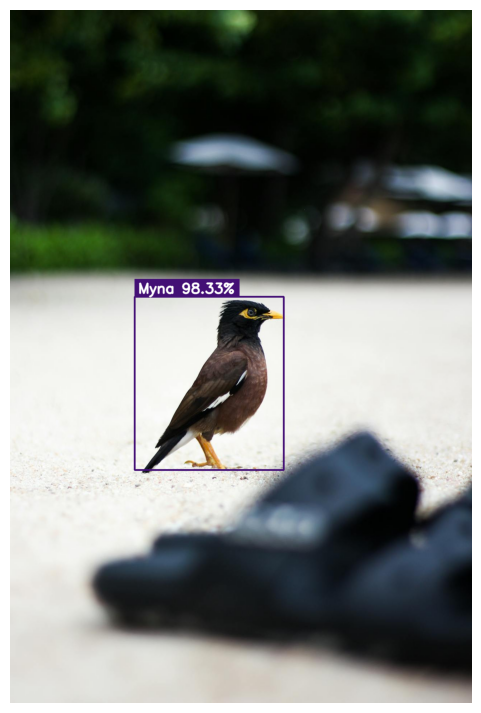

In [20]:
display_prediction(
    "DATA/IMAGES/test_images/myna_1.jpg",
    save_fig=True, 
    filename='myna_detected.jpg'
)


0: 640x480 2 Owls, 786.8ms
Speed: 33.0ms preprocess, 786.8ms inference, 15.1ms postprocess per image at shape (1, 3, 640, 480)
Image saved successfully at DATA/IMAGES/detected_images\owls_detected.jpg


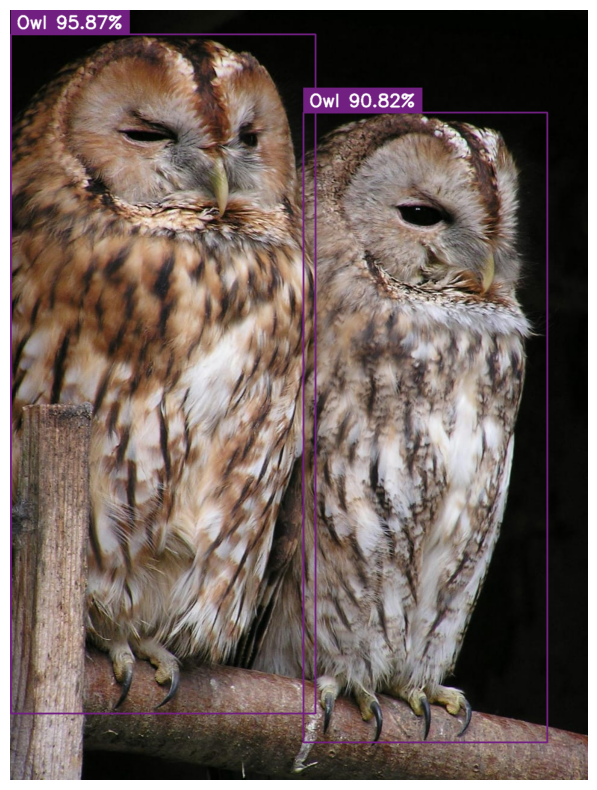

In [52]:
display_prediction(
    "DATA/IMAGES/test_images/owl_2.jpg",
    save_fig=True, 
    filename='owls_detected.jpg'
)


0: 448x640 1 Peacock, 1426.4ms
Speed: 12.0ms preprocess, 1426.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Image saved successfully at DATA/IMAGES/detected_images\peacocks_detected_1.jpg


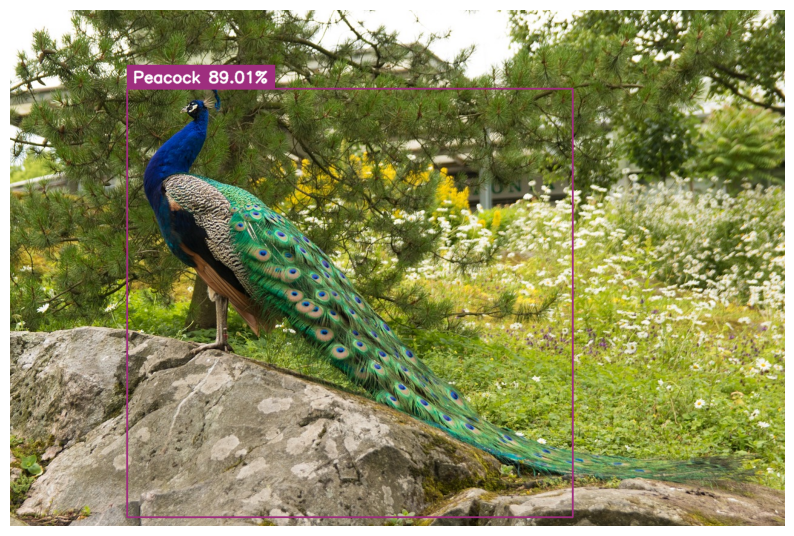

In [25]:
display_prediction(
    "DATA/IMAGES/test_images/peacocks_3.jpg",
    save_fig=True, 
    filename='peacocks_detected_1.jpg'
)

In [ ]:
display_prediction(
    "https://cdn.pixabay.com/photo/2020/02/27/13/21/rock-dove-4884627_1280.jpg",
    save_fig=True, 
    filename='pigeons_detected_1.jpg'
)

In [ ]:
display_prediction(
    'DATA/IMAGES/test_images/sparrow_3.jpg',
    save_fig=True, 
    filename='sparrow_detected_1.jpg'
)


0: 448x640 2 Sparrows, 1059.2ms
Speed: 10.0ms preprocess, 1059.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
Image saved successfully at DATA/IMAGES/detected_images\sparrow_detected_2.jpg


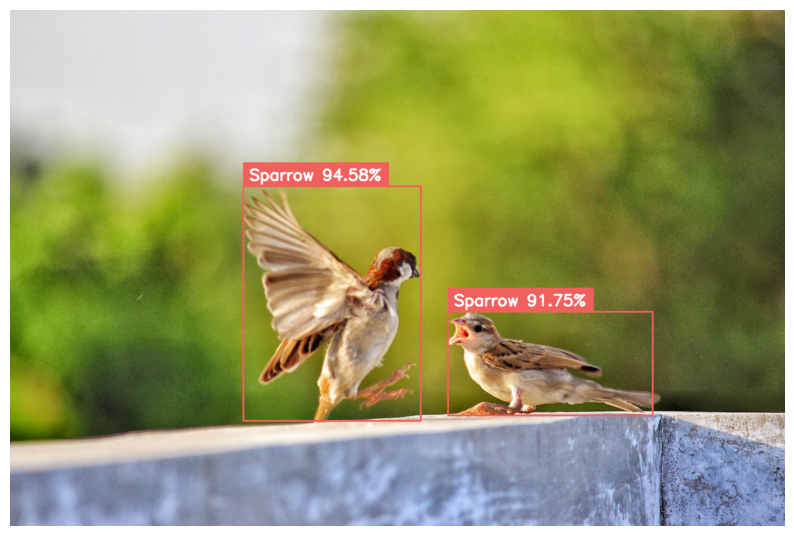

In [38]:
display_prediction(
    'DATA/IMAGES/test_images/sparrow_1.jpg',
    save_fig=True, 
    filename='sparrow_detected_2.jpg'
)

## Video Detection

Implementation for detecting and tracking birds in videos:

In [49]:
def predict_in_videos(video_path, save_video=False, filename=None):
    """
    Function to make predictions on video frames using a trained YOLO model and display the video with annotations.
    
    Parameters:
        video_path (str): Path to the video file.
        save_video (bool): If True, saves the video with annotations. Default is False.
        filename (str): The name of the output file where the video will be saved if save_video is True.
    """
    try:
        # Load video info and extract width, height, and frames per second (fps)
        video_info = sv.VideoInfo.from_video_path(video_path=video_path)
        w, h, fps = int(video_info.width), int(video_info.height), int(video_info.fps)

        # Calculate the optimal thickness for annotations and text scale based on video resolution
        thickness = sv.calculate_optimal_line_thickness(resolution_wh=video_info.resolution_wh)
        text_scale = sv.calculate_optimal_text_scale(resolution_wh=video_info.resolution_wh)

        # Initialize YOLO model, tracker, and color lookup for annotations
        box_annotator = sv.BoxAnnotator(thickness=thickness, color_lookup=sv.ColorLookup.TRACK)
        label_annotator = sv.LabelAnnotator(text_scale=text_scale, text_thickness=thickness, 
                                            text_position=sv.Position.TOP_LEFT,
                                            color_lookup=sv.ColorLookup.TRACK)
        
        model = YOLO("runs/detect/train/weights/best.pt")  # Load your custom-trained YOLO model
        tracker = sv.ByteTrack(frame_rate=fps)  # Initialize the tracker with the video's frame rate
        class_dict = model.names  # Get the class labels from the model

        # Directory to save the video with annotations, if required
        save_dir = "DATA/VIDEOS/detected_videos"
        if save_video and filename:
            os.makedirs(save_dir, exist_ok=True)  # Ensure save directory exists
            save_path = os.path.join(save_dir, filename)
            out = cv.VideoWriter(save_path, cv.VideoWriter_fourcc(*"XVID"), fps, (w, h))  # Initialize video writer

        # Capture the video from the given path
        cap = cv.VideoCapture(video_path)
        if not cap.isOpened():
            raise Exception("Error: couldn't open the video!")

        # Process the video frame by frame
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:  # End of the video
                break

            # Make predictions on the current frame using the YOLO model
            result = model(frame)[0]
            detections = sv.Detections.from_ultralytics(result)  # Convert model output to Detections format
            detections = tracker.update_with_detections(detections=detections)  # Track detected objects

            # Filter detections based on confidence
            if detections.tracker_id is not None:
                detections = detections[(detections.confidence > 0.5)]  # Keep detections with confidence > 0.5

                # Generate labels for tracked objects
                labels_0 = [f"#{trk_id} {class_dict[cls_id]} {conf*100:.2f}%" 
                            for trk_id, cls_id, conf in zip(
                            detections.tracker_id, detections.class_id, detections.confidence)]
                
                labels_1 = [f"{class_dict[cls_id]} {conf*100:.2f}%" for cls_id, conf in zip(
                            detections.class_id, detections.confidence)]

                # Annotate the frame with bounding boxes and labels
                box_annotator.annotate(frame, detections=detections)
                label_annotator.annotate(frame, detections=detections, labels=labels_1)

            # Save the annotated frame to the output video file if save_video is True
            if save_video and filename:
                out.write(frame)

            # Display the video frame with annotations
            # resized_frame = cv.resize(frame, (int(0.5*frame.shape[1]), int(0.5*frame.shape[0])))
            cv.imshow("Video", frame)

            # Break loop if 'p' key is pressed
            if cv.waitKey(1) & 0xff == ord('p'):
                break

    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        # Release resources
        cap.release()
        if save_video and filename:
            out.release()
        cv.destroyAllWindows()
        print("Video processing complete, Released resources.")


In [ ]:
predict_in_videos(
    "DATA/VIDEOS/test_videos/crows.mp4",
    save_video=True,
    filename='crows_detected.mp4'
)


In [ ]:
predict_in_videos(
    "DATA/VIDEOS/test_videos/kingfisher.mp4",
    save_video=True,
    filename='kingfisher_detected.mp4'
)


## Additional Notes and Best Practices

1. **Dataset Preparation**:

 - Ensure your dataset is well-balanced
 - Include images with varying lighting conditions
 - Consider data augmentation for better generalization


2. **Training Tips**:

 - Monitor training metrics in the runs/detect/train directory
 - Adjust confidence threshold based on your application needs
 - Consider using model ensembling for better results


3. **Production Deployment**:

 - Move API keys to environment variables
 - Implement proper error handling
 - Consider model quantization for faster inference

## GPU Requirements
This notebook was initially run on Google Colab with T4 GPU acceleration. Please adjust the batch size and image size according to your available GPU memory if you are running it elsewhere.